In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from PIL import Image
from sklearn.metrics import f1_score
import tensorflow as tf
import datetime

%load_ext autoreload
%autoreload 2
    
import ml_utils.road_seg as rs
import ml_utils.model as model
import ml_utils.data_augmentation as d_aug

# 1. Loading and Preprocessing

Load raw images and ground truth

In [2]:
path_data = 'data'
path_train_dir = os.path.join(path_data, 'training')
path_test = os.path.join(path_data, 'test_set_images')
path_models = 'model'

In [7]:
d_aug.genererate_data(path_train_dir, ratio=0.8, n_aug=400)


Split train set train/validation ...

Copy to sub folders ...

Generate augmented features - Train ...
Initialised with 80 image(s) found.
Output directory set to data/training/images/aug_train/.
Generate augmented features - Labels ...
Initialised with 80 image(s) found.
Output directory set to data/training/groundtruth/aug_train/.

In [8]:
train_imgs, train_gt, val_imgs, val_gt = rs.load_train_set(path_train_dir)

print('Shapes train: {},  test: {}'.format(train_imgs.shape, val_imgs.shape))
print('Shapes train: {},  test: {}'.format(train_gt.shape, val_gt.shape))

Loading train images ...
Loading train labels ...
Loading validation images ...
Loading validation labels ...
Shapes train: (90, 400, 400, 3),  test: (20, 400, 400, 3)
Shapes train: (90, 400, 400),  test: (20, 400, 400)


Generate smaller images for training

In [9]:
# train_imgs = rs.normalize_data(train_imgs, mode='image_wise') 
# val_imgs = rs.normalize_data(val_imgs, mode='image_wise') 
train_imgs, mean, std = rs.normalize_data(train_imgs, mode='all') 
val_imgs, _, _ = rs.normalize_data(val_imgs, mode='all', mean_ref = mean, std_ref = std) 

patch_size = 400
patch_tr, lab_tr,_ = rs.get_patches_all(train_imgs, train_gt, patch_size)

print('Shapes train: {}'.format(patch_tr.shape))
print('Shapes label: {}'.format(lab_tr.shape))

Shapes train: (2250, 80, 80, 3)
Shapes label: (2250, 80, 80)


Take only part of train and validation set (should at least contain a part of the road)

In [10]:
useful_patches_tr, useful_lab_tr = rs.get_useful_patches(patch_tr, lab_tr, 0.0, 1.0)
useful_lab_tr = useful_lab_tr.astype(int)

print('Shapes train: {}'.format(useful_patches_tr.shape))
print('Shapes lab: {}'.format(useful_lab_tr.shape))

Shapes train: (305, 80, 80, 3)
Shapes lab: (305, 80, 80)


Compute distance map

In [11]:
useful_lab_tr_dn = rs.get_penalize_values(useful_lab_tr)

Display patches example with label ground truth and distance map

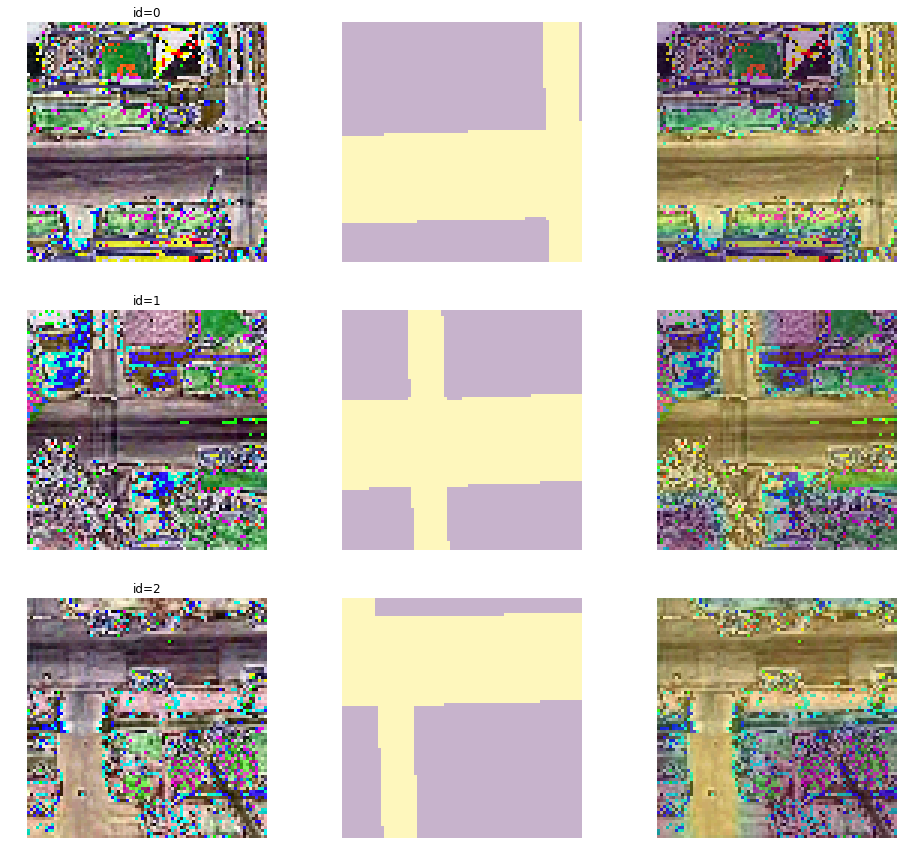

In [12]:
n_display = 3
#id_display = np.random.permutation(len(useful_patches_tr))[:n_display]
id_display = np.arange(n_display)

plt.figure(figsize=(16, 5*n_display))
for i, id_ in enumerate(id_display):
    plt.subplot(n_display,3,3*i+1)
    plt.imshow(useful_patches_tr[id_]); plt.axis('off'); plt.title('id={}'.format(id_display[i]))
    plt.subplot(n_display,3,3*i+2)
    plt.imshow(useful_lab_tr[id_], alpha=0.3); plt.axis('off');
    plt.subplot(n_display,3,3*i+3)
    plt.imshow(useful_patches_tr[id_]); plt.imshow(useful_lab_tr_dn[id_], alpha=0.3); plt.axis('off');
    # plt.imshow(useful_patches_tr[id_]); plt.imshow(useful_lab_tr[id_], alpha=0.3); plt.axis('off');

# 2. Model training


In [13]:

# useful_patches_tr = normalize_data(useful_patches_tr, mode='image_wise') 

# Compute mean according to train image
# _, mean_train, std_train = rs.normalize_data(train_imgs, mode='all')

# Substract mean for
# patches
# upatches_tr_norm, _, _ = rs.normalize_data(useful_patches_tr, mode='all', mean_ref=mean_train, std_ref=std_train)
# train and validation
# train_imgs_norm, _, _ = rs.normalize_data(train_imgs, mode='all', mean_ref=mean_train, std_ref=std_train)
# val_imgs_norm, _, _ = rs.normalize_data(val_imgs, mode='all', mean_ref=mean_train, std_ref=std_train)


In [93]:
import ml_utils.model as model

m = model.Model(model_type='gcnn', n_filters = 8)
m.train_model(useful_patches_tr, useful_lab_tr,
              train_imgs, train_gt, val_imgs, val_gt, n_epoch=50, display_epoch=1)

conv1 size (?, ?, ?, 64)
pool1 size (?, ?, ?, 64)
conv2 size (?, ?, ?, 128)
pool2 size (?, ?, ?, 128)
conv3 size (?, ?, ?, 256)
pool3 size (?, ?, ?, 256)
conv4 size (?, ?, ?, 512)
pool4 size (?, ?, ?, 512)
deconv1 size (?, ?, ?, 512)
deconv2 size (?, ?, ?, 256)
deconv3 size (?, ?, ?, 128)
deconv4 size (?, ?, ?, 64)
score size (?, ?, ?, 2)


/home/abbet/anaconda3/envs/pcml/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


KeyboardInterrupt: 

In [58]:
m.plot_stats()

No model path found


# 3. Results vizualisation


In [ ]:
m = model.Model(display_log=False)
d = m.get_model_layers(train_imgs[2], 'model/2017_12_08_21h58_model.ckpt')
m.plot_layers(train_imgs[2], d)

In [ ]:
y_pred_train = m.apply_model(train_imgs, 'model/2017_12_08_21h58_model.ckpt')
print('F1-score train: {}'.format(m.predict_f1(train_gt, y_pred_train)))
y_pred_valid = m.apply_model(val_imgs, 'model/2017_12_08_21h58_model.ckpt')
print('F1-score validation: {}'.format(m.predict_f1(val_gt, y_pred_valid)))

In [ ]:
rs.display_predictions(y_pred_train, train_imgs, train_gt)

In [ ]:
rs.display_predictions(y_pred_valid, val_imgs, val_gt)

# 4. Post Process

In [ ]:
test_img = rs.load_test_set(path_test)
test_img_norm, _, _ = rs.normalize_data(test_img, mode='all', mean_ref=mean, std_ref=std)

In [ ]:
m = model.Model(display_log=False)
y_pred_test = m.apply_model(test_img_norm, 'model/2017_12_08_21h58_model.ckpt')

In [ ]:
im_pred_test = np.reshape(y_pred_test, test_img.shape[:3]).astype(np.float32)
print(test_img.shape)
rs.display_predictions(y_pred_test, test_img)

In [ ]:
import skimage.measure
import skimage.draw
import skimage.morphology

def post_processing(imgs):
    imgs_post = np.zeros(imgs.shape)
    for i in range(imgs.shape[0]):
        imgs_post[i] = skimage.morphology.remove_small_objects(imgs[i].astype(bool), min_size = 200)    
    return imgs_post

im_pred_test_post = post_processing(im_pred_test)

In [ ]:
rs.display_predictions(y_pred_test, test_img, im_pred_test_post)

# 4. Submission

In [ ]:
rs.create_submission(im_pred_test_post, 'test_30epoch_post_dataaug.csv')